# T4 - Diffusion Models: Outpainting & Textual Refinement

Este notebook implementa duas das tarefas propostas no trabalho T4:
1.  **Outpainting:** Expansão de imagens além das bordas originais.
2.  **Textual Refinement:** Edição de partes da imagem guiada por texto.

Também inclui o cálculo das métricas **SSIM** e **LPIPS** para avaliação quantitativa.

## 1. Instalação e Configuração
Instalação das bibliotecas necessárias da Hugging Face e métricas.

In [ ]:
!pip install -q diffusers transformers accelerate torch opencv-python pillow torchmetrics lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.7 MB/s eta 0:00:00


In [3]:
import torch
from diffusers import StableDiffusionInpaintPipeline, ControlNetModel, StableDiffusionControlNetInpaintPipeline
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from PIL import Image, ImageOps, ImageFilter
import requests
from io import BytesIO
import numpy as np

# Setup Device (CUDA for Nvidia, MPS for Mac M1/M2, or CPU)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# Load the Inpainting Pipeline (Efficient for both Outpainting and Refinement)
model_id = "sd-legacy/stable-diffusion-inpainting"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16 if device == "cuda" else torch.float32,
    safety_checker=None # Disable safety checker to save memory/avoid false positives
).to(device)

# Optional ControlNet for structural guidance (e.g., Canny/edges)
controlnet_model_id = "lllyasviel/sd-controlnet-canny"
try:
    controlnet = ControlNetModel.from_pretrained(
        controlnet_model_id,
        torch_dtype=torch.float16 if device == "cuda" else torch.float32,
        use_safetensors=True
    )
    pipe_cn = StableDiffusionControlNetInpaintPipeline.from_pretrained(
        model_id,
        controlnet=controlnet,
        torch_dtype=torch.float16 if device == "cuda" else torch.float32,
        safety_checker=None
    ).to(device)
    print("ControlNet pipeline initialized.")
except Exception as e:
    print(f"ControlNet not available yet (" + str(e) + "). Falling back to base inpaint pipeline.")
    pipe_cn = None

# Load SegFormer for automatic semantic segmentation
print("\nLoading SegFormer for automatic mask generation...")
segformer_processor = SegformerImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
segformer_model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512").to(device)
segformer_model.eval()
print("SegFormer model loaded successfully.")

Using device: cpu


Loading pipeline components...:  67%|██████▋   | 4/6 [00:01<00:00,  3.14it/s]An error occurred while trying to fetch /home/flavex/.cache/huggingface/hub/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/flavex/.cache/huggingface/hub/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  67%|██████▋   | 4/6 [00:01<00:00,  3.14it/s]An error occurred while trying to fetch /home/flavex/.cache/huggingface/hub/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/flavex/.cache/huggingface/hub/models--sd-legacy--stable-diffusion-inpainting/snapshots/8a4288a76071f7280

ControlNet pipeline initialized.

Loading SegFormer for automatic mask generation...


/home/flavex/.pyenv/versions/cv/lib/python3.12/site-packages/transformers/image_processing_base.py:417: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type', 'reduce_labels'
  image_processor = cls(**image_processor_dict)


SegFormer model loaded successfully.


## 2. Funções Auxiliares
Função para baixar uma imagem de exemplo para testes.

In [5]:
# Download a sample image (Vermeer's Girl with a Pearl Earring is classic for outpainting tests)
url = "https://upload.wikimedia.org/wikipedia/commons/0/0f/1665_Girl_with_a_Pearl_Earring.jpg"
# Use wget to download the image silently
!wget -q -O original.png {url}

# Load the image using PIL after downloading
init_image = Image.open("original.png").convert("RGB").resize((512, 512))
print("Sample image downloaded and loaded.")

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:3452: DecompressionBombWarning: Image size (178746750 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Sample image downloaded and loaded.


In [6]:
def make_edge_control_image(image: Image.Image) -> Image.Image:
    """Create a simple edge-based control image from a PIL RGB image.
    Uses PIL's FIND_EDGES to avoid heavy dependencies. Returns RGB control image.
    """
    if image.mode != "RGB":
        image = image.convert("RGB")
    # Simple edges, invert to highlight structures
    edges = image.convert("L").filter(ImageFilter.FIND_EDGES)
    edges = ImageOps.invert(edges)
    control = Image.merge("RGB", (edges, edges, edges))
    return control

## 2.2. Segmentação Automática com SegFormer
Funções para gerar máscaras automaticamente usando SegFormer, identificando classes semânticas na imagem.

In [4]:
def segment_image(image: Image.Image):
    """
    Perform semantic segmentation on an image using SegFormer.
    Returns the segmentation map (numpy array with class IDs for each pixel).
    """
    # Prepare image for SegFormer
    inputs = segformer_processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Run inference
    with torch.no_grad():
        outputs = segformer_model(**inputs)
        logits = outputs.logits
    
    # Upsample to original image size
    upsampled_logits = torch.nn.functional.interpolate(
        logits,
        size=image.size[::-1],  # (height, width)
        mode="bilinear",
        align_corners=False
    )
    
    # Get predicted class for each pixel
    seg_map = upsampled_logits.argmax(dim=1)[0].cpu().numpy()
    return seg_map


def create_mask_from_classes(image: Image.Image, target_classes, invert=False):
    """
    Create a binary mask by selecting specific semantic classes.
    
    Args:
        image: PIL Image to segment
        target_classes: List of class IDs to include in mask (e.g., [12, 13] for person)
        invert: If True, mask everything EXCEPT the target classes
    
    Returns:
        PIL Image (mode 'L') where white=masked area, black=preserved area
    
    Common ADE20K class IDs:
    - 0: wall
    - 1: building
    - 2: sky
    - 3: floor
    - 4: tree
    - 12: person
    - 13: human face
    - 19: car
    - 20: grass
    - 67: door
    - 102: clothes
    """
    seg_map = segment_image(image)
    
    # Create binary mask
    mask_array = np.isin(seg_map, target_classes).astype(np.uint8) * 255
    
    if invert:
        mask_array = 255 - mask_array
    
    mask = Image.fromarray(mask_array, mode='L')
    return mask


def create_background_mask(image: Image.Image):
    """
    Automatically create a mask for the background (everything except people).
    Useful for background replacement tasks.
    """
    # Person-related classes in ADE20K
    person_classes = [12, 13]  # person, face
    # Mask everything except people (invert=True)
    return create_mask_from_classes(image, person_classes, invert=True)


def create_person_mask(image: Image.Image):
    """
    Automatically create a mask for people in the image.
    Useful for portrait editing tasks.
    """
    person_classes = [12, 13]  # person, face
    return create_mask_from_classes(image, person_classes, invert=False)


def visualize_segmentation(image: Image.Image, alpha=0.5):
    """
    Visualize the segmentation map overlaid on the original image.
    Returns a PIL Image with colored segments.
    """
    seg_map = segment_image(image)
    
    # Create color map (simple HSV-based coloring)
    num_classes = seg_map.max() + 1
    colors = np.zeros((num_classes, 3), dtype=np.uint8)
    for i in range(num_classes):
        hue = (i * 360 // num_classes) % 360
        # Simple HSV to RGB conversion for visualization
        colors[i] = [
            int(255 * (1 if hue < 60 or hue >= 300 else 0 if hue < 180 else 0)),
            int(255 * (1 if 60 <= hue < 180 else 0)),
            int(255 * (1 if 180 <= hue < 300 else 0))
        ]
    
    # Apply colors to segmentation map
    seg_colored = colors[seg_map]
    seg_img = Image.fromarray(seg_colored.astype(np.uint8))
    
    # Blend with original
    blended = Image.blend(image.convert('RGB'), seg_img, alpha)
    return blended

## 3. Implementação: Outpainting
Esta função cria um "canvas" maior, centraliza a imagem original e instrui o modelo a preencher o espaço vazio (branco na máscara).

In [8]:
def perform_outpainting(image, prompt, expand_factor=1.5, steps=50, use_controlnet=False, control_image=None, guidance_scale=7.5, generator=None):
    """
    Expands the image canvas and fills the new area using Stable Diffusion.
    Optionally uses ControlNet for structural guidance via a control image.
    """
    width, height = image.size
    new_width = int(width * expand_factor)
    new_height = int(height * expand_factor)

    # 1. Create a new canvas with gray background
    new_image = Image.new("RGB", (new_width, new_height), (128, 128, 128))

    # 2. Paste the original image in the center
    x_offset = (new_width - width) // 2
    y_offset = (new_height - height) // 2
    new_image.paste(image, (x_offset, y_offset))

    # 3. Create Mask: White area is filled, Black area is preserved
    mask = Image.new("L", (new_width, new_height), 255) # Start full white (fill everything)
    mask_black = Image.new("L", (width, height), 0) # Black box for original image
    mask.paste(mask_black, (x_offset, y_offset))

    # 4. Inference (with optional ControlNet)
    if use_controlnet and pipe_cn is None:
        print("Requested ControlNet, but pipeline not initialized. Using base inpainting.")
        use_controlnet = False

    if use_controlnet:
        ci = control_image if control_image is not None else make_edge_control_image(new_image)
        result = pipe_cn(
            prompt=prompt,
            image=new_image,
            mask_image=mask,
            control_image=ci,
            num_inference_steps=steps,
            strength=1.0,
            guidance_scale=guidance_scale,
            generator=generator
        ).images[0]
    else:
        result = pipe(
            prompt=prompt,
            image=new_image,
            mask_image=mask,
            num_inference_steps=steps,
            strength=1.0, # Strength 1.0 ensures the masked area is fully regenerated
            guidance_scale=guidance_scale,
            generator=generator
        ).images[0]

    return result, mask


In [9]:
# --- TEST OUTPAINTING ---
prompt_out = "classic oil painting, museum background, detailed frame, baroque style"
outpainted_img, out_mask = perform_outpainting(init_image, prompt_out)

outpainted_img.save("result_outpainting.png")
display(outpainted_img)

KeyboardInterrupt: 

## 4. Implementação: Textual Refinement
Usa o mesmo pipeline, mas focamos em alterar uma área existente. O parâmetro `strength` é crucial aqui: valores altos mudam completamente o objeto; valores baixos mantêm a estrutura original.

In [11]:
def perform_refinement(image, mask_image, prompt, strength=0.8, steps=50, use_controlnet=False, control_image=None, guidance_scale=7.5, generator=None):
    """
    Refines or replaces a specific area of the image defined by the mask.
    Optionally uses ControlNet for structural guidance.
    """
    # Resize image to 512x512 to save memory if needed
    image = image.resize((512, 512))
    mask_image = mask_image.resize((512, 512))

    if use_controlnet and pipe_cn is None:
        print("Requested ControlNet, but pipeline not initialized. Using base inpainting.")
        use_controlnet = False

    if use_controlnet:
        ci = control_image if control_image is not None else make_edge_control_image(image)
        result = pipe_cn(
            prompt=prompt,
            image=image,
            mask_image=mask_image,
            control_image=ci,
            num_inference_steps=steps,
            strength=strength, # Higher strength = more creative freedom away from original pixels
            guidance_scale=guidance_scale,
            generator=generator
        ).images[0]
    else:
        result = pipe(
            prompt=prompt,
            image=image,
            mask_image=mask_image,
            num_inference_steps=steps,
            strength=strength, # Higher strength = more creative freedom away from original pixels
            guidance_scale=guidance_scale,
            generator=generator
        ).images[0]

    return result

In [ ]:
# --- TEST REFINEMENT ---
# 1. Create a dummy mask (e.g., masking the bottom half to change clothes)
w, h = init_image.size
refinement_mask = Image.new("L", (w, h), 0)  # Black
refinement_mask.paste(255, (0, h // 2, w, h))  # White on bottom half

# 2. Run Refinement
prompt_refine = "a girl wearing a futuristic cyberpunk jacket, neon lights, high detail"
refined_img = perform_refinement(
    init_image, refinement_mask, prompt_refine, strength=0.85
)

refined_img.save("result_refinement.png")
display(refined_img)

# + Alguns testes (ControlNet)

  0%|          | 0/50 [00:00<?, ?it/s]

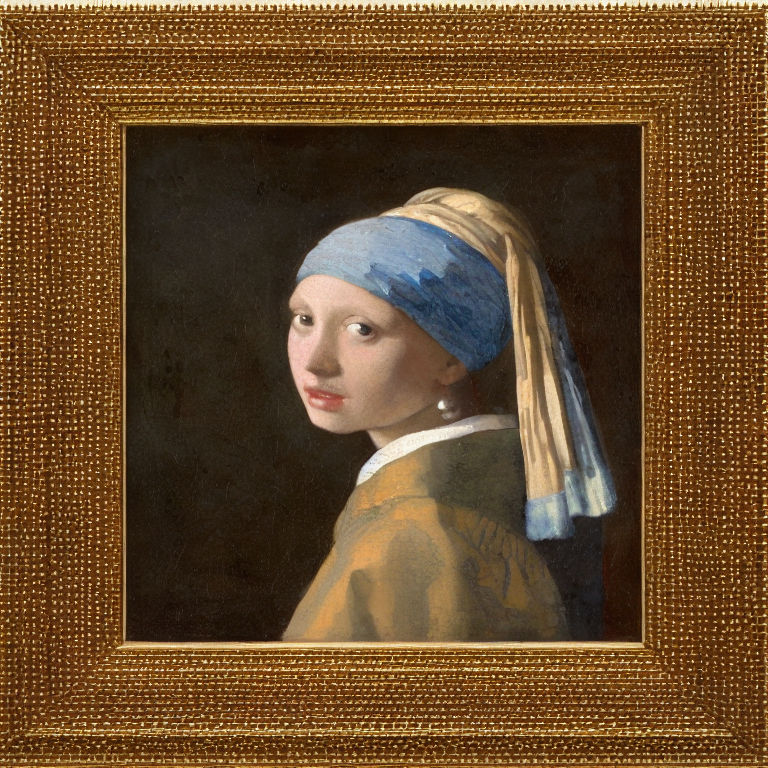

NameError: name 'refinement_mask' is not defined

In [8]:
# Outpainting com ControlNet (usando bordas como controle)
cn_out_img, cn_out_mask = perform_outpainting(
    init_image,
    prompt_out,
    use_controlnet=True,
)
cn_out_img.save("result_outpainting_controlnet.png")
display(cn_out_img)

# Refinement com ControlNet (mesma máscara de exemplo)
cn_refined_img = perform_refinement(
    init_image,
    refinement_mask,
    prompt_refine,
    strength=0.85,
    use_controlnet=True,
)
cn_refined_img.save("result_refinement_controlnet.png")
display(cn_refined_img)

## 4.2. Exemplos com Máscaras Automáticas (SegFormer)
Demonstra a criação automática de máscaras usando segmentação semântica.

=== Visualização da Segmentação ===

1. Imagem original:


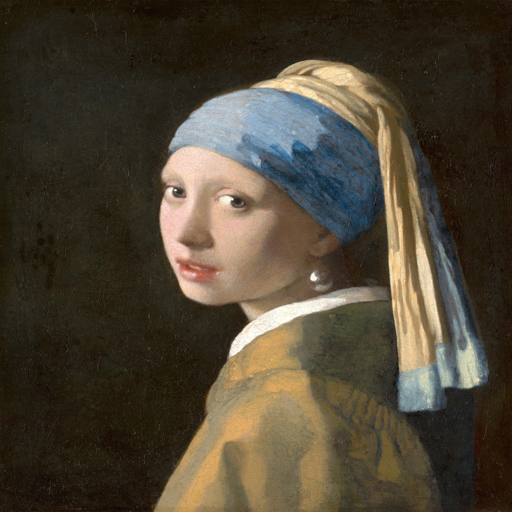


2. Mapa de segmentação sobreposto:


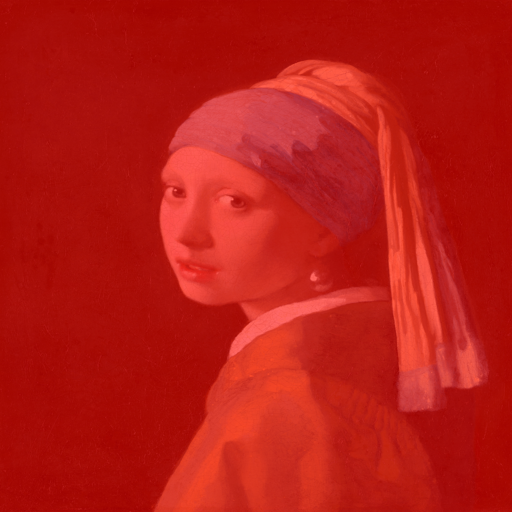

In [5]:
# Visualizar a segmentação automática
print("=== Visualização da Segmentação ===")
print("\n1. Imagem original:")
display(init_image)

print("\n2. Mapa de segmentação sobreposto:")
seg_viz = visualize_segmentation(init_image, alpha=0.6)
display(seg_viz)


=== Exemplo 1: Substituição Automática de Fundo ===



1. Máscara automática do fundo (branco = alterar):


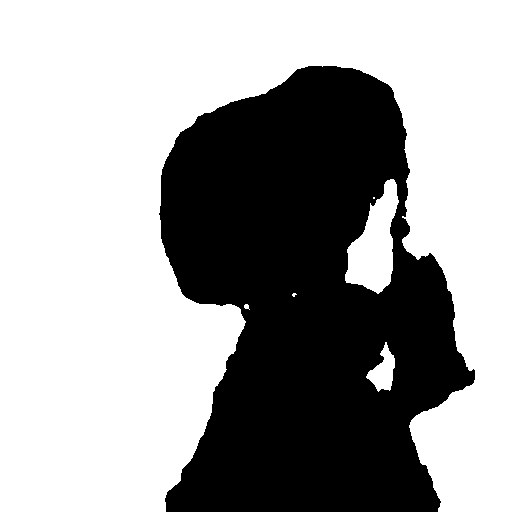

100%|██████████| 42/42 [04:38<00:00,  6.62s/it]



2. Resultado com fundo substituído:


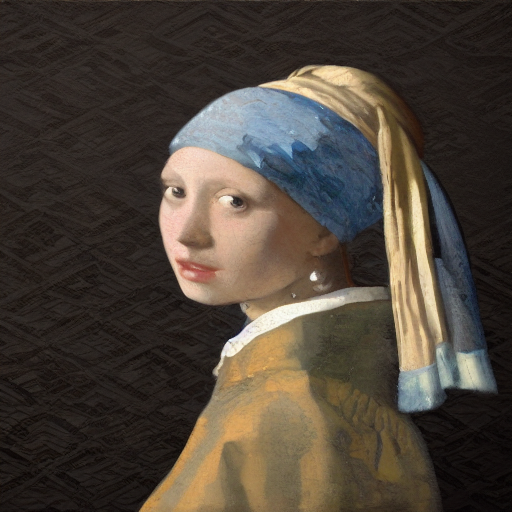

In [12]:
# Exemplo 1: Substituir o fundo automaticamente
print("\n=== Exemplo 1: Substituição Automática de Fundo ===")

# Criar máscara automática para o fundo (tudo exceto pessoas)
bg_mask = create_background_mask(init_image)

print("\n1. Máscara automática do fundo (branco = alterar):")
display(bg_mask)

# Aplicar refinement apenas no fundo
prompt_bg_auto = "abstract geometric patterns, modern art, vibrant colors, artistic background"
result_bg_auto = perform_refinement(init_image, bg_mask, prompt_bg_auto, strength=0.85, steps=50)

print("\n2. Resultado com fundo substituído:")
display(result_bg_auto)
result_bg_auto.save("result_auto_background_replacement.png")

In [ ]:
# Exemplo 2: Editar apenas a pessoa/rosto
print("\n=== Exemplo 2: Edição Automática de Pessoa ===")

# Criar máscara automática para pessoas
person_mask = create_person_mask(init_image)

print("\n1. Máscara automática de pessoas (branco = alterar):")
display(person_mask)

# Aplicar refinement apenas na pessoa
prompt_person_auto = "cyberpunk character, futuristic outfit, neon details, high tech clothing"
result_person_auto = perform_refinement(init_image, person_mask, prompt_person_auto, strength=0.75, steps=50)

print("\n2. Resultado com pessoa editada:")
display(result_person_auto)
result_person_auto.save("result_auto_person_edit.png")

In [15]:
# Imagens naturais para testes de segmentação automática
natural_image_urls = [
    'https://i.ibb.co/jZRvX4wp/nature.png',
    'https://i.ibb.co/jvCWYjbN/nature2.png'
    ]

# Baixa imagens
for idx, url in enumerate(natural_image_urls):
    !wget -q -O natural_{idx}.png {url}


=== Exemplo 3: Máscara Personalizada por Classes ===

1. Máscara para céu/árvores/grama (branco = alterar):

1. Máscara para céu/árvores/grama (branco = alterar):


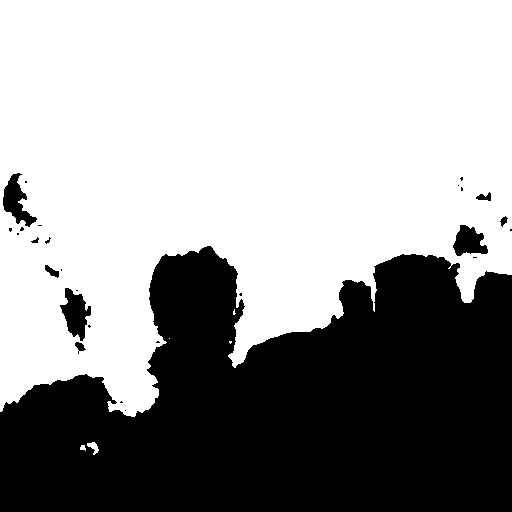


2. Máscara para céu/árvores/grama (branco = alterar):


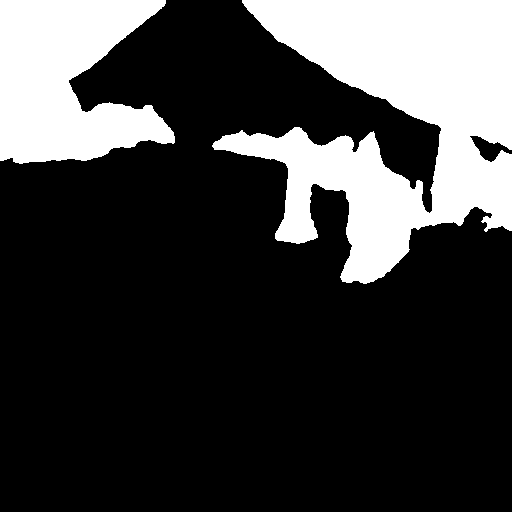

100%|██████████| 40/40 [04:33<00:00,  6.84s/it]




2. Resultado com áreas naturais editadas (imagem 1):


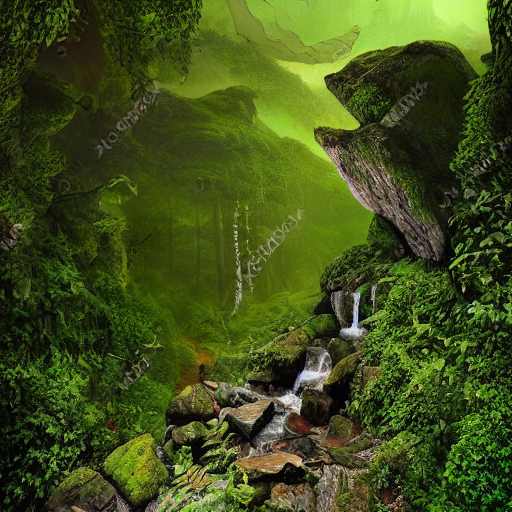

100%|██████████| 40/40 [04:36<00:00,  6.92s/it]




2. Resultado com áreas naturais editadas (imagem 2):


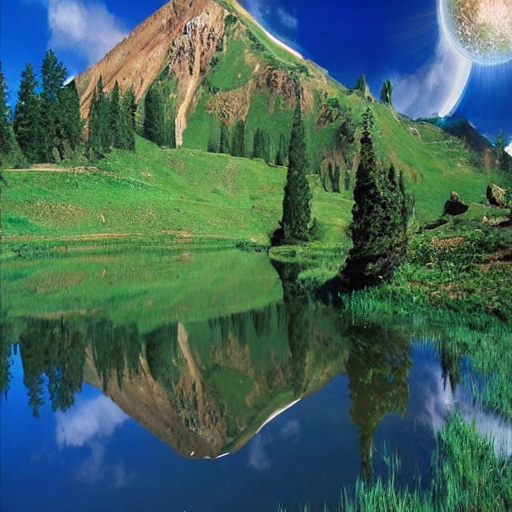

In [16]:
# Exemplo 3: Máscara personalizada por classes específicas
print("\n=== Exemplo 3: Máscara Personalizada por Classes ===")

# Carregar uma imagem natural
natural_img_0 = Image.open("natural_0.png").convert("RGB").resize((512, 512))
natural_img_1 = Image.open("natural_1.png").convert("RGB").resize((512, 512))

# Criar máscara para classes específicas (ex: céu, árvores)
# Classes comuns ADE20K: 2=céu, 4=árvore, 20=grama
sky_tree_classes = [2, 4, 20]
custom_mask_0 = create_mask_from_classes(natural_img_0, sky_tree_classes, invert=False)
custom_mask_1 = create_mask_from_classes(natural_img_1, sky_tree_classes, invert=False)

print("\n1. Máscara para céu/árvores/grama (branco = alterar):")
display(custom_mask_0)
print("\n2. Máscara para céu/árvores/grama (branco = alterar):")
display(custom_mask_1)

# Aplicar refinement nessas áreas
prompt_nature = "fantasy landscape, magical atmosphere, ethereal lighting, mystical nature"
result_0 = perform_refinement(natural_img_0, custom_mask_0, prompt_nature, strength=0.8, steps=50)
print("\n1. Resultado com áreas naturais editadas (imagem 1):")
display(result_0)
result_0.save("result_0_custom_classes.png")
result_1 = perform_refinement(natural_img_1, custom_mask_1, prompt_nature, strength=0.8, steps=50)
print("\n2. Resultado com áreas naturais editadas (imagem 2):")
display(result_1)
result_1.save("result_1_custom_classes.png")

In [ ]:
# Exemplo 4: Combinando SegFormer + ControlNet
print("\n=== Exemplo 4: Segmentação Automática + ControlNet ===")

# Usar máscara de fundo automática com ControlNet para controle estrutural
bg_mask_cn = create_background_mask(init_image)

print("\n1. Máscara automática do fundo:")
display(bg_mask_cn)

# Aplicar com ControlNet para melhor controle estrutural
prompt_bg_cn = "professional studio background, soft lighting, bokeh effect, photography backdrop"
result_bg_cn = perform_refinement(
    init_image, 
    bg_mask_cn, 
    prompt_bg_cn, 
    strength=0.8, 
    steps=50,
    use_controlnet=True
)

print("\n2. Resultado com ControlNet + máscara automática:")
display(result_bg_cn)
result_bg_cn.save("result_auto_segformer_controlnet.png")

## 5. Avaliação (Métricas Perceptuais)
Cálculo de SSIM (estrutural) e LPIPS (perceptual, baseada em VGG).

In [ ]:
from torchmetrics import StructuralSimilarityIndexMeasure
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity
import torchvision.transforms.functional as TF

def calculate_metrics(img_path_a, img_path_b):
    # Load images
    img_a = Image.open(img_path_a).convert("RGB").resize((512, 512))
    img_b = Image.open(img_path_b).convert("RGB").resize((512, 512))

    # Convert to Tensor and normalize to [0, 1]
    tensor_a = TF.to_tensor(img_a).unsqueeze(0).to(device) # Shape: (1, 3, H, W)
    tensor_b = TF.to_tensor(img_b).unsqueeze(0).to(device)

    # 1. SSIM (Higher is better, max 1.0)
    ssim = StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    score_ssim = ssim(tensor_a, tensor_b)

    # 2. LPIPS (Lower is better, 0.0 means identical)
    # net_type='vgg' is standard for perceptual comparison
    lpips = LearnedPerceptualImagePatchSimilarity(net_type='vgg').to(device)
    score_lpips = lpips(tensor_a * 2 - 1, tensor_b * 2 - 1) # LPIPS expects [-1, 1] range usually

    return score_ssim.item(), score_lpips.item()

# Calculate metrics between Original and Refined
s_val, l_val = calculate_metrics("original.png", "result_refinement.png")

print(f"--- Metrics (Original vs Refined) ---")
print(f"SSIM: {s_val:.4f} (Structural Similarity)")
print(f"LPIPS: {l_val:.4f} (Perceptual Distance)")
print("Note: For Outpainting, crop the center of the result before comparing if you want to measure fidelity of the preserved area.")

/usr/local/lib/python3.12/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 73.0MB/s]


--- Metrics (Original vs Refined) ---
SSIM: 0.5789 (Structural Similarity)
LPIPS: 0.4359 (Perceptual Distance)
Note: For Outpainting, crop the center of the result before comparing if you want to measure fidelity of the preserved area.


## 6. Experimentos com Diferentes Imagens e Máscaras

Esta seção contém vários experimentos interessantes com diferentes tipos de imagens, máscaras e prompts para demonstrar a versatilidade das técnicas de outpainting e refinement.


In [ ]:
# Download multiple test images for experiments
import os

# Create images directory if it doesn't exist
os.makedirs("experiments", exist_ok=True)

# Download different types of images
image_urls = {
    "portrait": "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4f/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/256px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg",
    "landscape": "https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/PNG_transparency_demonstration_1.png/256px-PNG_transparency_demonstration_1.png",
    "architecture": "https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Eiffel_Tower_icon.svg/256px-Eiffel_Tower_icon.svg.png",
    "mona": "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ec/Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg/500px-Mona_Lisa%2C_by_Leonardo_da_Vinci%2C_from_C2RMF_retouched.jpg"
}

# Download a landscape image (using a different approach)
!wget -q -O experiments/landscape.jpg "https://images.unsplash.com/photo-1506905925346-21bda4d32df4?w=512&h=512&fit=crop"
!wget -q -O experiments/portrait.jpg "https://images.unsplash.com/photo-1494790108377-be9c29b29330?w=512&h=512&fit=crop"
!wget -q -O experiments/object.jpg "https://images.unsplash.com/photo-1523275335684-37898b6baf30?w=512&h=512&fit=crop"

!wget -q -O experiments/monalisa.jpg image_urls["mona"]

print("Test images downloaded for experiments.")


Test images downloaded for experiments.


### Experimento 1: Outpainting com Paisagem - Expandindo Horizontes

Landscape image loaded.


  0%|          | 0/50 [00:00<?, ?it/s]

=== Experimento 1: Outpainting de Paisagem ===

1. Imagem original centralizada:


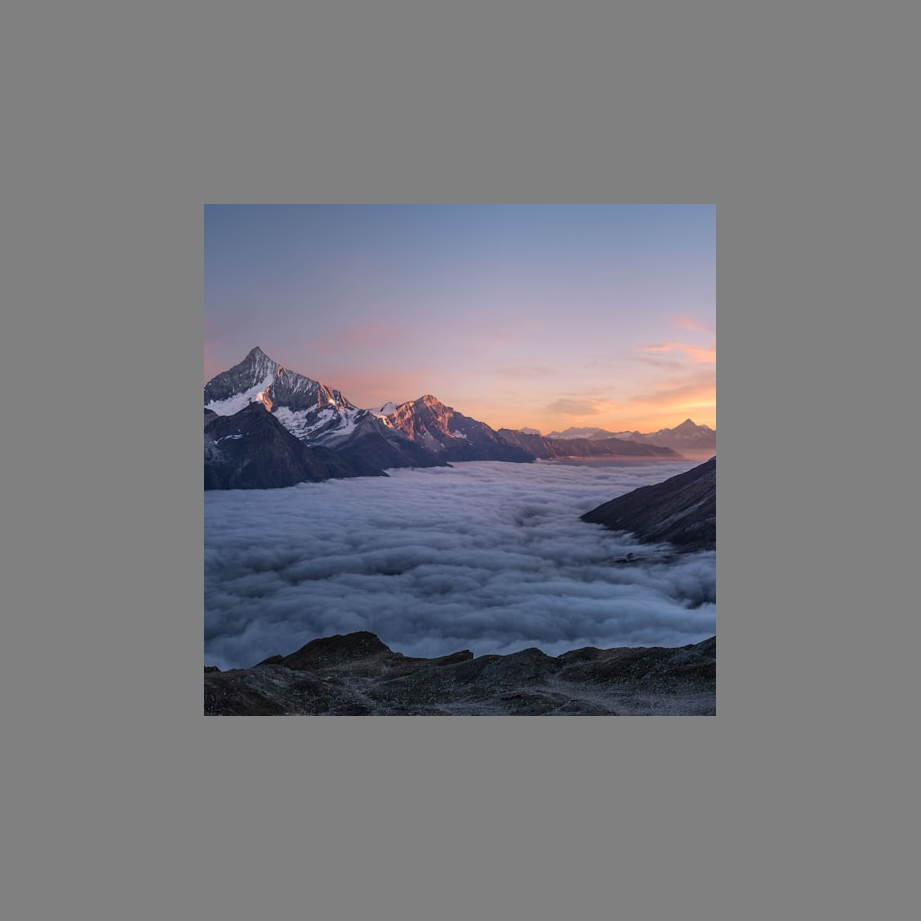


2. Máscara (branco = preencher, preto = preservar):


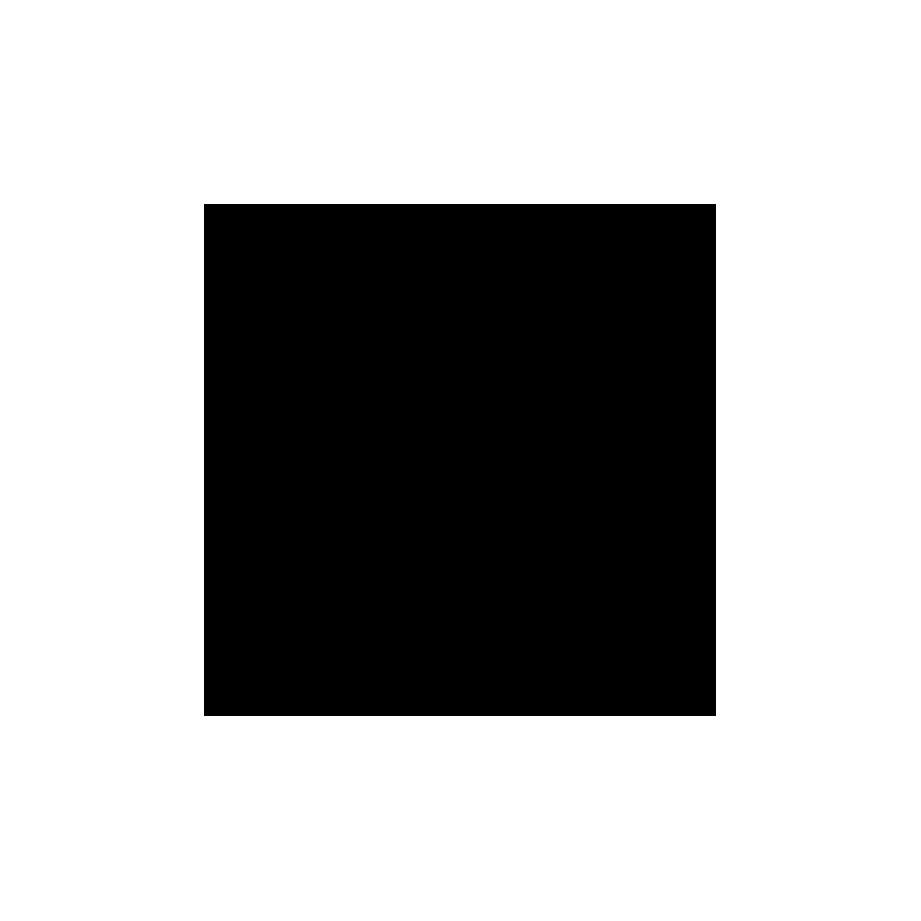


3. Resultado final:


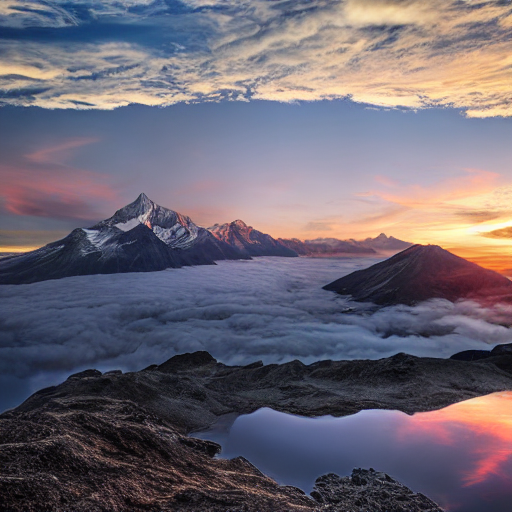

In [ ]:
# Load landscape image
try:
    landscape_img = Image.open("experiments/landscape.jpg").convert("RGB").resize((512, 512))
    print("Landscape image loaded.")
except:
    # Fallback: create a simple landscape
    landscape_img = Image.new("RGB", (512, 512), (135, 206, 235))  # Sky blue
    from PIL import ImageDraw
    draw = ImageDraw.Draw(landscape_img)
    # Draw simple landscape
    draw.rectangle([0, 300, 512, 512], fill=(34, 139, 34))  # Ground
    draw.ellipse([100, 100, 200, 200], fill=(255, 255, 255))  # Cloud
    landscape_img.save("experiments/landscape.jpg")
    print("Created simple landscape image.")

# Outpainting: Expand landscape horizontally
prompt_landscape = "beautiful mountain range, sunset sky, dramatic clouds, cinematic lighting, high detail"
outpainted_landscape, mask_landscape, centered_landscape = perform_outpainting(
    landscape_img,
    prompt_landscape,
    expand_factor=1.8,
    steps=50
)

print("=== Experimento 1: Outpainting de Paisagem ===")
print("\n1. Imagem original centralizada:")
display(centered_landscape)

print("\n2. Máscara (branco = preencher, preto = preservar):")
display(mask_landscape)

print("\n3. Resultado final:")
display(outpainted_landscape)

outpainted_landscape.save("experiments/outpainting_landscape.png")


### Experimento 2: Refinement com Máscara Circular - Mudando o Fundo


Portrait image loaded.


  0%|          | 0/45 [00:00<?, ?it/s]

=== Experimento 2: Refinement com Máscara Circular ===

1. Imagem original:


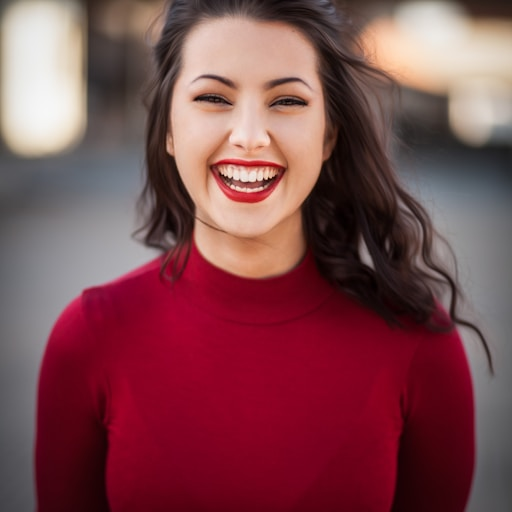


2. Máscara circular (preto = preservar, branco = alterar):


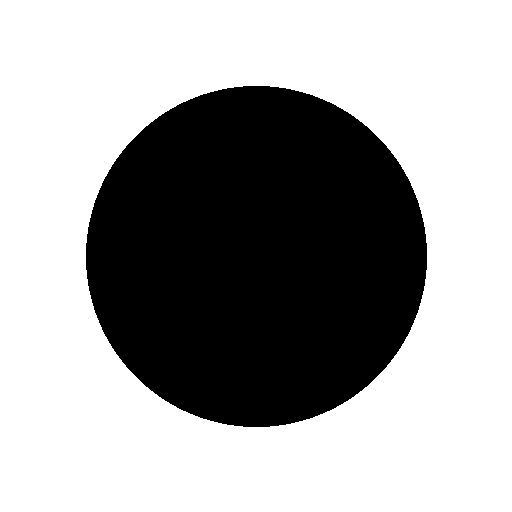


3. Resultado com fundo alterado:


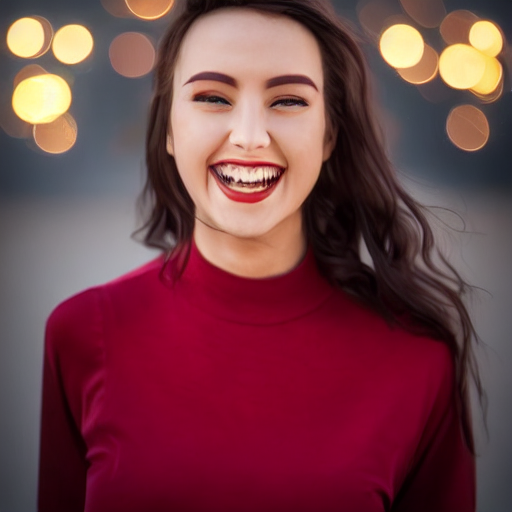

In [ ]:
# Load portrait image
try:
    portrait_img = Image.open("experiments/portrait.jpg").convert("RGB").resize((512, 512))
    print("Portrait image loaded.")
except:
    # Fallback: use the original image
    portrait_img = init_image.copy()
    print("Using original image as portrait.")

# Create circular mask (preserve center, change background)
w, h = portrait_img.size
circular_mask = Image.new("L", (w, h), 255)  # White = change
from PIL import ImageDraw
draw = ImageDraw.Draw(circular_mask)
center_x, center_y = w // 2, h // 2
radius = min(w, h) // 3
draw.ellipse(
    [center_x - radius, center_y - radius, center_x + radius, center_y + radius],
    fill=0  # Black = preserve (center subject)
)

# Refinement: Change background
prompt_bg = "futuristic cityscape at night, neon lights, cyberpunk atmosphere, bokeh effect"
refined_portrait = perform_refinement(portrait_img, circular_mask, prompt_bg, strength=0.9, steps=50)

print("=== Experimento 2: Refinement com Máscara Circular ===")
print("\n1. Imagem original:")
display(portrait_img)

print("\n2. Máscara circular (preto = preservar, branco = alterar):")
display(circular_mask)

print("\n3. Resultado com fundo alterado:")
display(refined_portrait)

refined_portrait.save("experiments/refinement_circular_mask.png")


### Experimento 3: Refinement com Máscara Retangular - Substituindo Objetos

Object image loaded.


  0%|          | 0/42 [00:00<?, ?it/s]

=== Experimento 3: Refinement com Máscara Retangular ===

1. Imagem original:


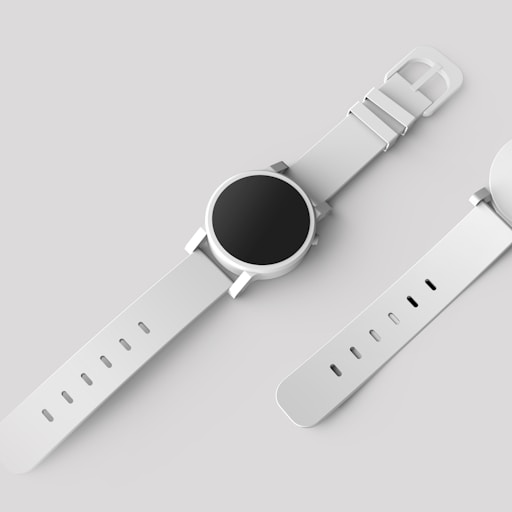


2. Máscara retangular (preto = preservar, branco = alterar):


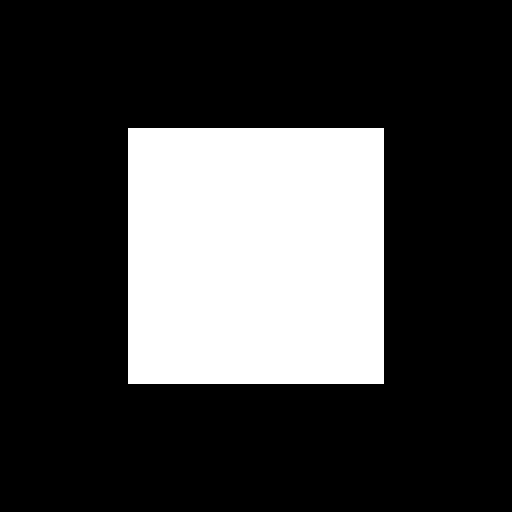


3. Resultado com objeto substituído:


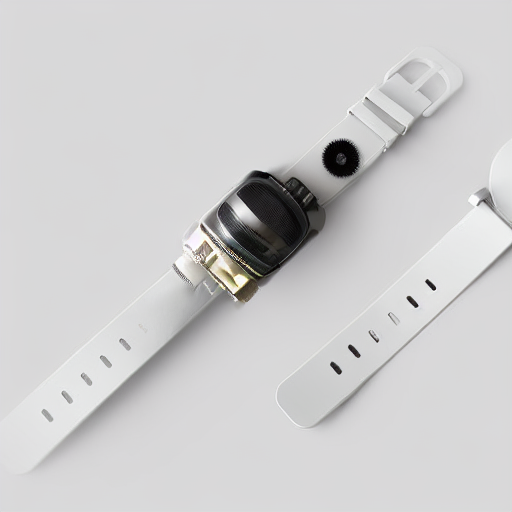

In [ ]:
# Load object image
try:
    object_img = Image.open("experiments/object.jpg").convert("RGB").resize((512, 512))
    print("Object image loaded.")
except:
    # Fallback: use a simple colored image
    object_img = Image.new("RGB", (512, 512), (200, 150, 100))
    from PIL import ImageDraw
    draw = ImageDraw.Draw(object_img)
    draw.rectangle([150, 150, 362, 362], fill=(100, 50, 200))
    object_img.save("experiments/object.jpg")
    print("Created simple object image.")

# Create rectangular mask (mask a specific region)
w, h = object_img.size
rectangular_mask = Image.new("L", (w, h), 0)  # Black = preserve
# Mask the center region
mask_x1, mask_y1 = w // 4, h // 4
mask_x2, mask_y2 = 3 * w // 4, 3 * h // 4
rectangular_mask.paste(255, (mask_x1, mask_y1, mask_x2, mask_y2))  # White = change

# Refinement: Replace object
prompt_object = "vintage camera, leather texture, brass details, professional photography equipment"
refined_object = perform_refinement(object_img, rectangular_mask, prompt_object, strength=0.85, steps=50)

print("=== Experimento 3: Refinement com Máscara Retangular ===")
print("\n1. Imagem original:")
display(object_img)

print("\n2. Máscara retangular (preto = preservar, branco = alterar):")
display(rectangular_mask)

print("\n3. Resultado com objeto substituído:")
display(refined_object)

refined_object.save("experiments/refinement_rectangular_mask.png")


### Experimento 4: Outpainting Vertical - Expandindo para Cima e Baixo

In [ ]:
# Use portrait for vertical outpainting
try:
    portrait_vertical = Image.open("experiments/mona.jpg").convert("RGB").resize((512, 512))
except NameError:
    # Fallback if portrait_img not defined
    portrait_vertical = init_image.copy()

# Custom outpainting function for vertical expansion
def perform_vertical_outpainting(image, prompt, expand_factor=1.5, steps=50):
    """Expands image vertically (top and bottom)."""
    width, height = image.size
    new_width = width  # Keep same width
    new_height = int(height * expand_factor)

    # Create canvas
    new_image = Image.new("RGB", (new_width, new_height), (128, 128, 128))

    # Paste original in vertical center
    x_offset = 0
    y_offset = (new_height - height) // 2
    new_image.paste(image, (x_offset, y_offset))

    # Create mask
    mask = Image.new("L", (new_width, new_height), 255)
    mask_black = Image.new("L", (width, height), 0)
    mask.paste(mask_black, (x_offset, y_offset))

    # Inference
    result = pipe(
        prompt=prompt,
        image=new_image,
        mask_image=mask,
        num_inference_steps=steps,
        strength=1.0
    ).images[0]

    return result, mask, new_image

prompt_vertical = "classic oil painting, museum background, detailed frame, baroque style"
outpainted_vertical, mask_vertical, centered_vertical = perform_vertical_outpainting(
    portrait_vertical,
    prompt_vertical,
    expand_factor=1.5,
    steps=50
)

print("=== Experimento 4: Outpainting Vertical ===")
print("\n1. Imagem original centralizada verticalmente:")
display(centered_vertical)

print("\n2. Máscara:")
display(mask_vertical)

print("\n3. Resultado final:")
display(outpainted_vertical)

outpainted_vertical.save("experiments/outpainting_vertical.png")


FileNotFoundError: [Errno 2] No such file or directory: 'experiments/mona.jpg'

### Experimento 5: Refinement com Máscara Irregular - Adicionando Elementos


In [ ]:
# Create irregular mask (polygon shape)
from PIL import ImageDraw
w, h = init_image.size
irregular_mask = Image.new("L", (w, h), 0)  # Black = preserve
draw = ImageDraw.Draw(irregular_mask)

# Draw an irregular polygon (e.g., for adding a hat or accessory)
points = [
    (w // 2 - 80, h // 3),
    (w // 2 + 80, h // 3),
    (w // 2 + 100, h // 3 + 60),
    (w // 2 - 100, h // 3 + 60),
]
draw.polygon(points, fill=255)  # White = change

# Refinement: Add something to the masked area
prompt_irregular = "elegant vintage hat, feathers, detailed texture, sophisticated style"
refined_irregular = perform_refinement(init_image, irregular_mask, prompt_irregular, strength=0.8, steps=50)

print("=== Experimento 5: Refinement com Máscara Irregular ===")
print("\n1. Imagem original:")
display(init_image)

print("\n2. Máscara irregular (preto = preservar, branco = alterar):")
display(irregular_mask)

print("\n3. Resultado com elemento adicionado:")
display(refined_irregular)

refined_irregular.save("experiments/refinement_irregular_mask.png")


### Experimento 6: Comparação de Strength - Efeito do Parâmetro

In [ ]:
# Compare different strength values
w, h = init_image.size
test_mask = Image.new("L", (w, h), 0)
test_mask.paste(255, (w // 4, h // 4, 3 * w // 4, 3 * h // 4))

prompt_strength = "abstract art, vibrant colors, modern style, high detail"

strengths = [0.3, 0.6, 0.9]
results_strength = []

print("=== Experimento 6: Comparação de Strength ===")
print("\n1. Imagem original:")
display(init_image)

print("\n2. Máscara de teste:")
display(test_mask)

for strength in strengths:
    result = perform_refinement(init_image, test_mask, prompt_strength, strength=strength, steps=40)
    results_strength.append((strength, result))
    print(f"\n3.{strengths.index(strength) + 1}. Resultado com strength={strength}:")
    display(result)
    result.save(f"experiments/refinement_strength_{strength}.png")

print("\n=== Resumo ===")
print("Strength baixo (0.3): Mantém mais da estrutura original")
print("Strength médio (0.6): Balance entre original e novo conteúdo")
print("Strength alto (0.9): Mais liberdade criativa, maior mudança")


### Experimento 7: Outpainting com Diferentes Estilos Artísticos

In [ ]:
# Test different artistic styles for outpainting
artistic_prompts = {
    "Baroque": "ornate baroque frame, gold details, classical museum setting, dramatic lighting",
    "Modern": "minimalist modern gallery, white walls, contemporary art space, clean design",
    "Fantasy": "magical fantasy realm, mystical atmosphere, ethereal background, dreamlike"
}

results_artistic = []

print("=== Experimento 7: Outpainting com Diferentes Estilos ===")
print("\n1. Imagem original:")
display(init_image)

for style_name, prompt in artistic_prompts.items():
    result, mask, centered = perform_outpainting(init_image, prompt, expand_factor=1.5, steps=45)
    results_artistic.append((style_name, result))

    print(f"\n2. Estilo: {style_name}")
    print(f"   Prompt: {prompt}")
    display(result)
    result.save(f"experiments/outpainting_{style_name.lower()}.png")

print("\n=== Resumo ===")
print("Diferentes prompts artísticos produzem contextos completamente diferentes")
print("para a expansão da imagem, demonstrando a flexibilidade do modelo.")
